### Classifying the CIFAR10 dataset here

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

### Get the data

In [2]:
t1 = transforms.ToTensor()
t2 = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
trans = transforms.Compose([t1, t2])

# Train 
trainset = torchvision.datasets.CIFAR10(root='/home/as/datasets/cifar10', 
                                        train=True, download=True, transform=trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, 
                                          num_workers=2)

# Test
testset = torchvision.datasets.CIFAR10(root='/home/as/datasets/cifar10', 
                                        train=False, download=True, transform=trans)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, 
                                          num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### See the images

 frog   car  bird horse


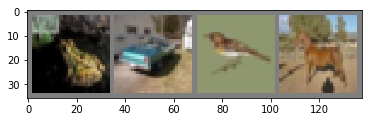

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define the model

In [5]:
class Cifar10Net(nn.Module):
    
    """
        Input is 32x32x1 sized images (CIFAR10)       32x32x3
        conv1 6 filters of 5x5, 0 padding, 1 stride   28x28x6
        relu                                          28x28x6
        pool1 2x2, 2 strides                          14x14x6
        conv2 16 filters of 5x5, 0 padding, 1 stride  10x10x16
        relu                                          10x10x16
        pool2 2x2, 2 strides                           5x5x16
        fully connected 120 nodes                         120
        fully connected 84 nodes                           84
        fully connected 10 nodes                           10 
        MSE loss function
    """
    
    def __init__(self):
        super(Cifar10Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(5*5*16, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        
        return x

In [6]:
net = Cifar10Net()
net.cuda()

Cifar10Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

### Loss function and Optimizer

In [7]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [8]:
for epoch in range(2):
    
    epoch_loss = 0.0
    for i, batchdata in enumerate(trainloader, 0):
        inputs, labels = batchdata
        inputs, labels = autograd.Variable(inputs.cuda()), autograd.Variable(labels.cuda())
        
        optimizer.zero_grad()
        output = net(inputs)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data[0]
        
        if i%2000 == 0:
            print('Epoch:', epoch, 'Batch iteration:', i, 'Loss:', epoch_loss/2000)
            epoch_loss = 0
        
        
print('Done')

Epoch: 0 Batch iteration: 0 Loss: 0.0011646698713302613
Epoch: 0 Batch iteration: 2000 Loss: 2.19233014947176
Epoch: 0 Batch iteration: 4000 Loss: 1.9517610145509243
Epoch: 0 Batch iteration: 6000 Loss: 1.7319014235138892
Epoch: 0 Batch iteration: 8000 Loss: 1.6314795060157776
Epoch: 0 Batch iteration: 10000 Loss: 1.5368128085136414
Epoch: 0 Batch iteration: 12000 Loss: 1.506371664315462
Epoch: 1 Batch iteration: 0 Loss: 0.0007953428030014039
Epoch: 1 Batch iteration: 2000 Loss: 1.4058183402866125
Epoch: 1 Batch iteration: 4000 Loss: 1.414156326904893
Epoch: 1 Batch iteration: 6000 Loss: 1.3816630088835955
Epoch: 1 Batch iteration: 8000 Loss: 1.3465624429136516
Epoch: 1 Batch iteration: 10000 Loss: 1.3411956821382045
Epoch: 1 Batch iteration: 12000 Loss: 1.304856601178646
Done


GroundTruth:  truck  deer   cat  ship


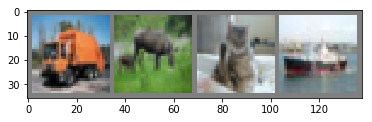

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(autograd.Variable(images.cuda()))

In [11]:
outputs

Variable containing:

Columns 0 to 7 
  0.5811   0.5465  -2.3466  -0.4063  -3.2168  -2.7278  -3.0205   0.7450
  0.0565  -3.1379   2.3913   0.0813   4.1325  -0.2921   0.8013   3.2254
  0.9519  -2.4280   1.3961   1.0700   0.5501  -0.2252   1.3723  -0.8677
  4.3972   1.0400  -0.6497  -2.3574  -1.4664  -3.9147  -2.9181  -3.3478

Columns 8 to 9 
  0.5257  10.1008
 -3.6720  -3.7228
 -0.5327  -2.0963
  7.7759   3.6074
[torch.cuda.FloatTensor of size 4x10 (GPU 0)]

In [12]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  truck  deer  bird  ship


In [13]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = net(autograd.Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    
    #print(type(predicted))
    #print(type(outputs))
    
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %
